In [10]:
import tempfile
import numpy as np

In [59]:
def midplane_velocity_profile(ax, pos, u, h, N, marker, color):
    size = 10 
    y_min = min(pos[1])
    y_max = max(pos[1])
    midpoint = (y_max - y_min)/2
    xs = pos[0]
    ys = pos[1]
    midplane = [i for i, (_, y) in enumerate(zip(xs, ys)) if abs(y - midpoint) < h]
    xs_midplane = [xs[i] for i in midplane]
    uy_midplane = [u[1][i] for i in midplane]
    ax.scatter(xs_midplane, uy_midplane, s=size, color=color, marker=marker, facecolors='none')
    ax.set_xlabel('$p_x$')
    ax.set_ylabel('$u_y$')
    ax.set_title(f"Cross section velocity for N = {N}")

# Execute all versions of lid driven cavity problem

In [12]:
from pathlib import Path
from xml.etree import ElementTree
path = "bin"
programs = {
    "Lid driven cavity": ("SparseLUWrapper", "SparseLUWrapper"),
    "Lid driven cavity QR GPU": ("QR", "SparseLUWrapper"),
    # "Lid driven cavity iterative GPU" : "lidDrivenIterativeGPU" # useless...
    "Lid driven cavity GPU with DSS" : ("DSS", "SparseLUWrapper"),
    "Lid driven cavity GPU with DSS and RF" : ("DSS", "RF")
}
hs = [h/1000.0 for h in range(20, 2, -2)]
# hs = np.linspace(0.002, 0.02, 20)
param_directory = tempfile.TemporaryDirectory()

Create parameter files

In [13]:
def get_output_path(program, h):
    h_str = str(h)[2:]
    return Path("benchmark", "results", f"lidDriven_{program}_{h_str}_result.h5")
def get_param_path(param_dir, program, h):
    h_str = str(h)[2:]
    return Path(param_dir.name, f"chanelFlow_{program}_{h_str}.xml")

In [14]:
parameter_path = Path("..", "params")
default_param = parameter_path / "chanelFlow.xml"
for name, (solver_u, solver_p) in programs.items():
    params_tree = ElementTree.parse(default_param)
    root = params_tree.getroot()
    for h in hs:
        num_xml = root.find("./num")
        num_xml.set('h', str(h))
        case_xml = root.find("./case")
        case_xml.set('solver_u', solver_u)
        case_xml.set('solver_p', solver_p)
        output = root.find("./output")
        output.set("hdf5_name", str(Path('..') / get_output_path(f"{solver_u}_{solver_p}", h)))
        param_output_path = get_param_path(param_directory, f"{solver_u}_{solver_p}", h)
        params_tree.write(param_output_path)

Run program for every parameter file

In [15]:
import subprocess
from concurrent.futures.process import ProcessPoolExecutor
def run_lid_driven(param_file):
    subprocess.run(["../bin/lidDriven", param_file])
parameter_dir = Path("..", "params", "benchmark")
to_run = []
for param_file in Path(param_directory.name).glob("*.xml"):
    params_tree = ElementTree.parse(param_file)
    root = params_tree.getroot()
    output_xml = root.find("./output")
    output_path = Path(output_xml.get("hdf5_name"))
    if Path.exists(output_path):
        continue
    to_run.append(param_file)
list(map(run_lid_driven, to_run))
# with ProcessPoolExecutor(4) as pool:
#     pool.map(run_lid_driven, to_run)


[]

Display benchmarking results

In [16]:
import matplotlib.pyplot as plt
import h5py
import numpy as np

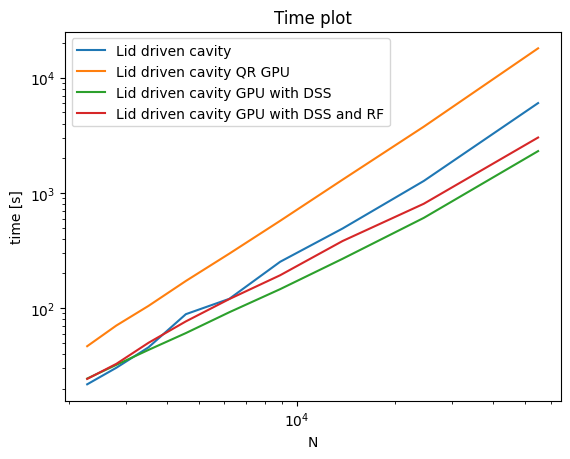

In [55]:
fig, ax = plt.subplots()
for name, (solver_u, solver_p) in programs.items():
    ts = []
    Ns = []
    for h in hs:
        result_file = Path("..") / get_output_path(f"{solver_u}_{solver_p}", h)
        with h5py.File(result_file) as f:
            time = f['times'].attrs["time"]
            N = len(f["domain/pos"][()][0])
            Ns.append(N)
            ts.append(time)
    ax.plot(Ns, ts, label=name)
# plt.gca().invert_xaxis()
ax.set_xlabel('N')
ax.set_ylabel('time [s]')
plt.yscale('log')
plt.xscale('log')
ax.set_title("Time plot")
ax.legend()

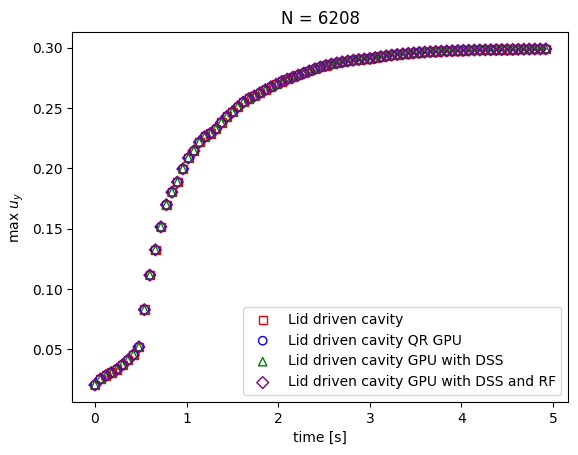

In [58]:
# fig, axs = plt.subplots(len(hs), figsize=(8,32))
# for i, h in enumerate(hs):
#     for name, (solver_u, solver_p) in programs.items():
#         result_file = Path('..') / get_output_path(f"{solver_u}_{solver_p}", h)
#         with h5py.File(result_file) as f:
#             velocity = np.array(f['max_u_y'], dtype=np.float64)
#             xs = list(range(len(velocity[0])))
#             axs[i].plot(xs, velocity[0], label=name)
#             axs[i].set_title('Maximum midplane velocity')
#             axs[i].set_xlabel('time')
#             axs[i].set_ylabel('max $u_y$')
#             axs[i].legend()
# fig, axs = plt.subplots(3, 3, figsize=(16,16))
fig, ax= plt.subplots()
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['s', 'o', '^', 'D']
# for i, h in enumerate(hs):
j = 0
h = hs[4]
for name, (solver_u, solver_p) in programs.items():
    result_file = Path('..') / get_output_path(f"{solver_u}_{solver_p}", h)
    with h5py.File(result_file) as f:
        velocity = np.array(f['max_u_y'], dtype=np.float64)
        dt = f.attrs['num.cfl'] * f.attrs['num.h'] / f.attrs['case.dim']
        xs = [dt * step for step in range(len(velocity[0]))]
        ax.scatter(xs, velocity[0], label=name, color=colors[j], facecolors='none', marker=markers[j])
        ax.legend(loc='lower right')
        ax.set_xlabel('time [s]')
        ax.set_ylabel('max $u_y$')
        N = len(f['domain/pos'][0])
        ax.set_title(f"N = {N}")
        j += 1


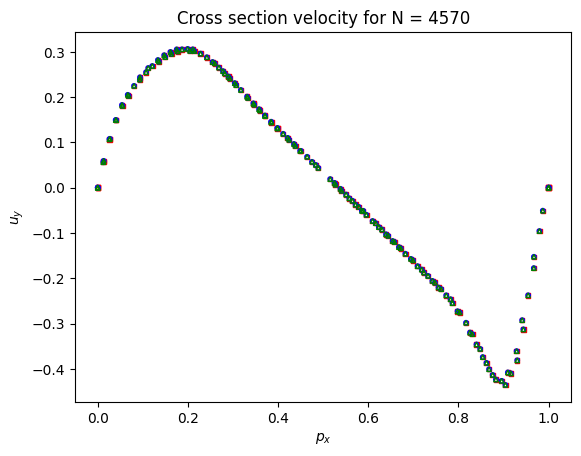

In [60]:
# fig, axs = plt.subplots(3, 3, figsize=(16,16))
fig, ax = plt.subplots()
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['s', 'o', '^', '+', 'D']
# for i, h in enumerate(hs):
h = hs[3]
for j, (name, (solver_u, solver_p)) in enumerate(programs.items()):
    result_file = Path('..') / get_output_path(f"{solver_u}_{solver_p}", h)
    with h5py.File(result_file) as f:
        u = np.array(f['velocity'], dtype=np.float64)
        pos = np.array(f['domain/pos'], dtype=np.float64)
        N = len(f['domain/pos'][0])
        midplane_velocity_profile(ax, pos, u, h, N, markers[j], colors[j])

In [72]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
times = {"domain setup": "domain setup", 
         "M_p construction": r'\Nabla \cdot \vec{v}^* = \frac{\Delta t}{\rho}\Nabla p', 
         "M_u construction": r"M_u construction", 
         "M_u solve": """M_u solve""", 
         "rhs_p": r"rhs_p", 
         "M_p solve": r"M_p solve", 
         "pressure correction": r"pressure correction", 
         }
plt.rcParams['text.usetex'] = True
for i, (name, (solver_u, solver_p)) in enumerate(programs.items()):
    ts = {} 
    for time_name in times.keys():
        ts[time_name] = []
    Ns = []
    for h in hs:
        result_file = Path("..") / get_output_path(f"{solver_u}_{solver_p}", h)
        with h5py.File(result_file) as f:
            # time = f.attrs["time"] - f.attrs["setup"]
            for time_name, formated_name in times.items():
                ts[time_name].append(f['times'].attrs[time_name])
            # total = sum(ts)
            # ts = [t/total for t in ts]
            N = len(f["domain/pos"][()][0])
            Ns.append(N)
    sorted_names = []
    col_total = np.zeros(len(hs))
    values = []
    # total = np.array(len())
    for time_name, value in ts.items():
        sorted_names.append(times[time_name])
        col_total += value
        values.append(value)

    for j in range(len(values)):
        values[j] /= col_total
    values = np.vstack(values)
    ax[i//2][i%2].stackplot(Ns, values, labels=sorted_names)
    ax[i//2][i%2].legend()
    ax[i//2][i%2].set_title(name)
    ax[i//2][i%2].set_xlabel("N")
    ax[i//2][i%2].set_ylabel("time [%]")

Error in callback <function _draw_all_if_interactive at 0x79972d6cdab0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1600x1200 with 4 Axes>

In [34]:
programs_acm = {
    # "Lid driven cavity ACM": "lidDrivenACM",
    "Lid driven cavity matrix ACM": "lidDrivenMatrixACM",
    "Lid driven cavity matrix GPU ACM": "lidDrivenMatrixACMGPU"
}
hs_acm = [h / 1000.0 for h in range(20, 0, -2)] + [1 / 1000.0]
# hs_acm = np.linspace(0.001, 0.02, 20)
acm_parameter_dir = tempfile.TemporaryDirectory()

[0.02, 0.018, 0.016, 0.014, 0.012, 0.01, 0.008, 0.006, 0.004, 0.002, 0.001]


In [ ]:
parameter_path = Path("..", "params")
default_param = parameter_path / "chanelFlowACM.xml"
for name, program in programs_acm.items():
    params_tree = ElementTree.parse(default_param)
    root = params_tree.getroot()
    for h in hs_acm:
        num_xml = root.find("./num")
        num_xml.set('h', str(h))
        output = root.find("./output")
        output.set("hdf5_name", str(Path('..') / get_output_path(program, h)))
        case_xml = root.find("./case")
        case_xml.set('program', program)
        param_output_path = get_param_path(acm_parameter_dir, program, h)
        params_tree.write(param_output_path)

In [ ]:
import subprocess
import os
from concurrent.futures.process import ProcessPoolExecutor
def run_lid_driven_acm(program, param_file):
    subprocess.run([f"../bin/{program}", param_file])
parameter_dir = Path("..", "params", "benchmark")
to_run = []
to_run_programs = []
for param_file in Path(acm_parameter_dir.name).glob("*.xml"):
    params_tree = ElementTree.parse(param_file)
    root = params_tree.getroot()
    output_xml = root.find("./output")
    output_path = Path(output_xml.get("hdf5_name"))
    if Path.exists(output_path):
        print(f"Skipping: {output_path}")
        continue
    print(f"Executing {output_path}")
    case_xml = root.find("./case")
    program = case_xml.get("program")
    # to_run.append((program, param_file))
    to_run_programs.append(program)
    to_run.append(param_file)
print(to_run)
# with ProcessPoolExecutor(1) as pool:
    # pool.map(run_lid_driven_acm, to_run_programs, to_run)
list(map(run_lid_driven_acm, to_run_programs, to_run))


Skipping: ../benchmark/lidDriven_lidDrivenMatrixACMGPU_06_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACMGPU_14_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACM_18_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACMGPU_08_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACM_20_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACM_06_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACMGPU_12_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACMGPU_02_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACMGPU_04_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACM_08_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACM_12_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACMGPU_16_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACMGPU_10_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACM_02_result.h5
Skipping: ../benchmark/lidDriven_lidDrivenMatrixACM_04_result.h5
S

[]

../benchmark/lidDriven_lidDrivenMatrixACM_20_result.h5
../benchmark/lidDriven_lidDrivenMatrixACM_18_result.h5
../benchmark/lidDriven_lidDrivenMatrixACM_16_result.h5
../benchmark/lidDriven_lidDrivenMatrixACM_14_result.h5
../benchmark/lidDriven_lidDrivenMatrixACM_12_result.h5
../benchmark/lidDriven_lidDrivenMatrixACM_10_result.h5
../benchmark/lidDriven_lidDrivenMatrixACM_08_result.h5
../benchmark/lidDriven_lidDrivenMatrixACM_06_result.h5
../benchmark/lidDriven_lidDrivenMatrixACM_04_result.h5
../benchmark/lidDriven_lidDrivenMatrixACM_02_result.h5
../benchmark/lidDriven_lidDrivenMatrixACMGPU_20_result.h5
../benchmark/lidDriven_lidDrivenMatrixACMGPU_18_result.h5
../benchmark/lidDriven_lidDrivenMatrixACMGPU_16_result.h5
../benchmark/lidDriven_lidDrivenMatrixACMGPU_14_result.h5
../benchmark/lidDriven_lidDrivenMatrixACMGPU_12_result.h5
../benchmark/lidDriven_lidDrivenMatrixACMGPU_10_result.h5
../benchmark/lidDriven_lidDrivenMatrixACMGPU_08_result.h5
../benchmark/lidDriven_lidDrivenMatrixACMGPU

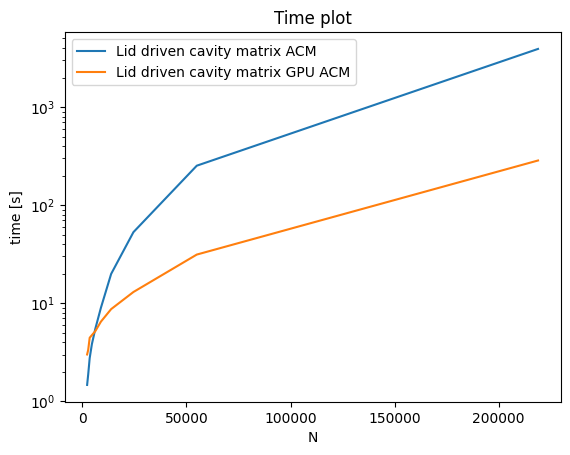

In [ ]:
fig, ax = plt.subplots()
for name, program in programs_acm.items():
    ts = []
    Ns = []
    for h in hs_acm:
        result_file = Path("..") / get_output_path(program, h)
        print(result_file)
        with h5py.File(result_file) as f:
            time = f.attrs["times/time"] - f.attrs["times/setup"]
            N = len(f["domain/pos"][()][0])
            Ns.append(N)
            ts.append(time)
            # print(name)
    ax.plot(Ns, ts, label=name)
# plt.gca().invert_xaxis()
ax.set_xlabel('N')
ax.set_ylabel('time [s]')
plt.yscale('log')
ax.set_title("Time plot")
ax.legend()

[None, None]

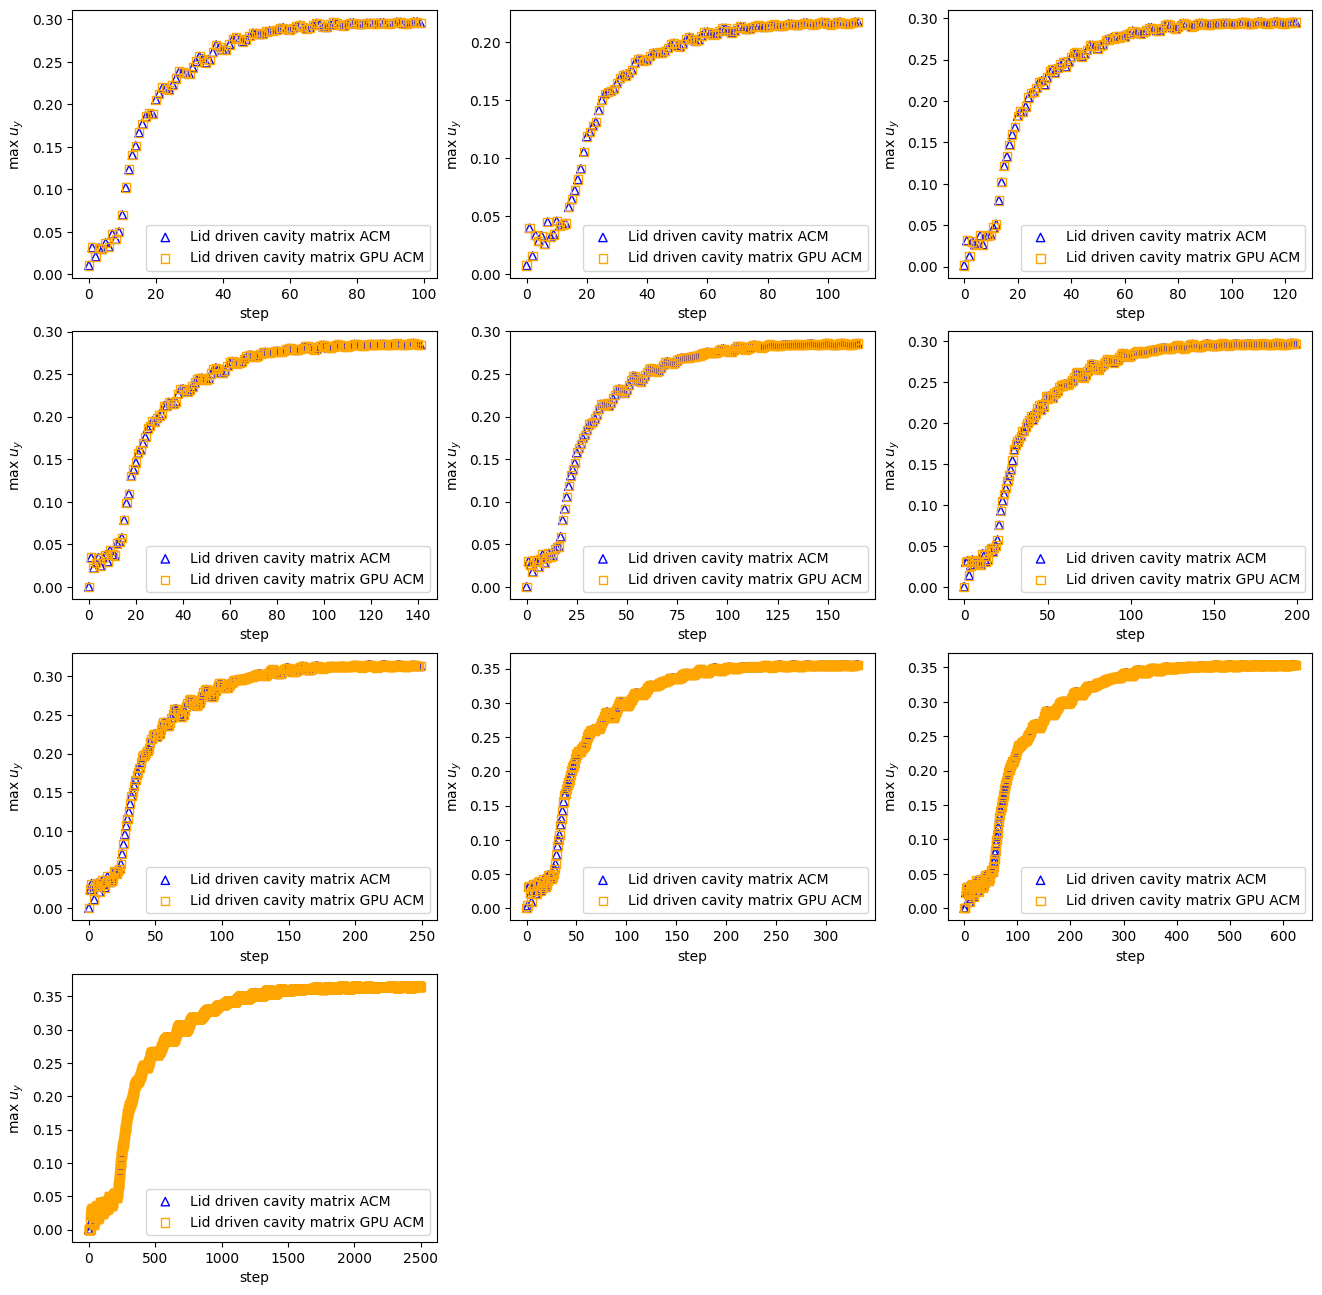

In [ ]:
# fig, axs = plt.subplots(4, 3, figsize=(16,16))
fig, ax = plt.subplots()
markers = ['^', 's']
colors = ['blue', 'orange']
# for i, h in enumerate(hs_acm):
j = 0
for name, program in programs_acm.items():
    result_file = Path('..') / get_output_path(program, h)
    with h5py.File(result_file) as f:
        velocity = np.array(f['max_u_y'], dtype=np.float64)
        dt = f['dt']
        xs = [dt * step for step in range(len(velocity[0]))]
        ax.scatter(xs, velocity[0], label=name, color=colors[j], facecolors='none', marker=markers[j])
        ax.legend()
        ax.set_xlabel('step')
        ax.set_ylabel('max $u_y$')
        ax.set_title(f"h = {h}")
        j += 1
# [fig.delaxes(ax) for ax in axs.flatten() if not ax.has_data()]

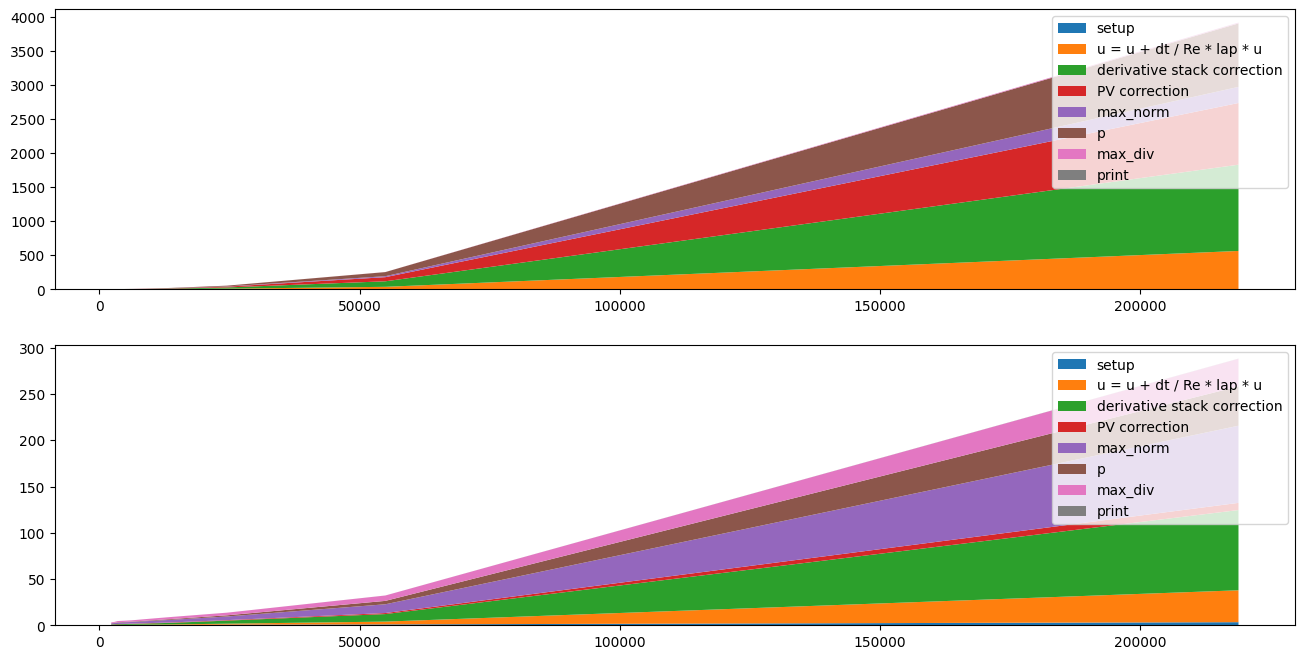

In [ ]:
fig, ax = plt.subplots(2, figsize=(16, 8))
times = {"setup": "setup", 
         "u = u + dt / Re * lap * u": """$\vec{v}^* = \vec{v} + 
         \Delta t \left( \nu \nabla^2 \vec{v} \right)$""", 
         "advection": r"\vec{v} \cdot \nabla\vec{v}", 
         "PV correction": """\vec{p} & \leftarrow \vec{p} - \Delta t C^2  \rho  (\nabla \cdot \vec{v}),""", 
         "max_norm": r"\max_i(\lVert\vec{v_i}\rVert_2)", 
         "p": r"\vec{p} & \leftarrow \vec{p} - \Delta t C^2  \rho  (\nabla \cdot \vec{v}),", 
         "max_div": r"\lVert\nabla \cdot \vec{v}\rVert_{\infty}", 
         "print": "print"}
for i, (name, program) in enumerate(programs_acm.items()):
    ts = {} 
    for time_name in times.keys():
        ts[time_name] = []
    Ns = []
    for h in hs_acm:
        result_file = Path("..") / get_output_path(program, h)
        with h5py.File(result_file) as f:
            # time = f.attrs["time"] - f.attrs["setup"]
            for time_name, formated_name in times.items():
                ts[time_name].append(f.attrs[time_name])
            total = sum(ts)
            ts = [t/total for t in ts]
            N = len(f["domain/pos"][()][0])
            Ns.append(N)
    sorted_names = []
    col_total = np.array(len(hs_acm))
    values = []
    # total = np.array(len())
    for time_name, value in ts.values():
        sorted_names.append(time_name)
        col_total += value
        values.append(value)

    for i in range(len(values)):
        values[i] /= col_total
    values = np.vstack(values)
    ax[i].stackplot(Ns, values, labels=sorted_names)
    ax[i].legend()
    # ax[i].set_yscale("log")

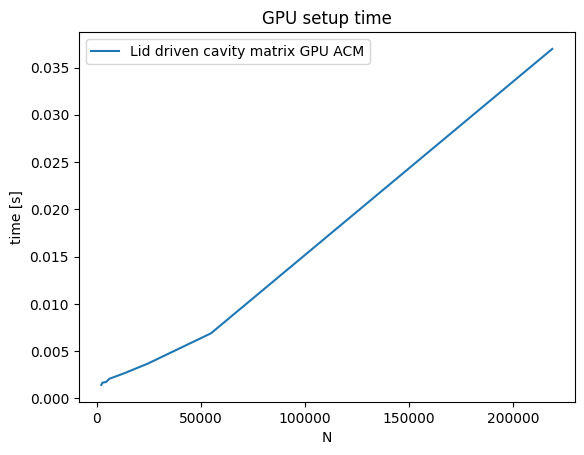

In [ ]:
fig, ax = plt.subplots()
for name, program in programs_acm.items():
    if program == "lidDrivenMatrixACM":
        continue
    ts = []
    Ns = []
    for h in hs_acm:
        result_file = Path("..") / get_output_path(program, h)
        with h5py.File(result_file) as f:
            time = f.attrs["gpu setup"]
            N = len(f["domain/pos"][()][0])
            Ns.append(N)
            ts.append(time)
    ax.plot(Ns, ts, label=name)
# plt.gca().invert_xaxis()
ax.set_xlabel('N')
ax.set_ylabel('time [s]')
# plt.yscale('log')
ax.set_title("GPU setup time")
ax.legend()

[None, None]

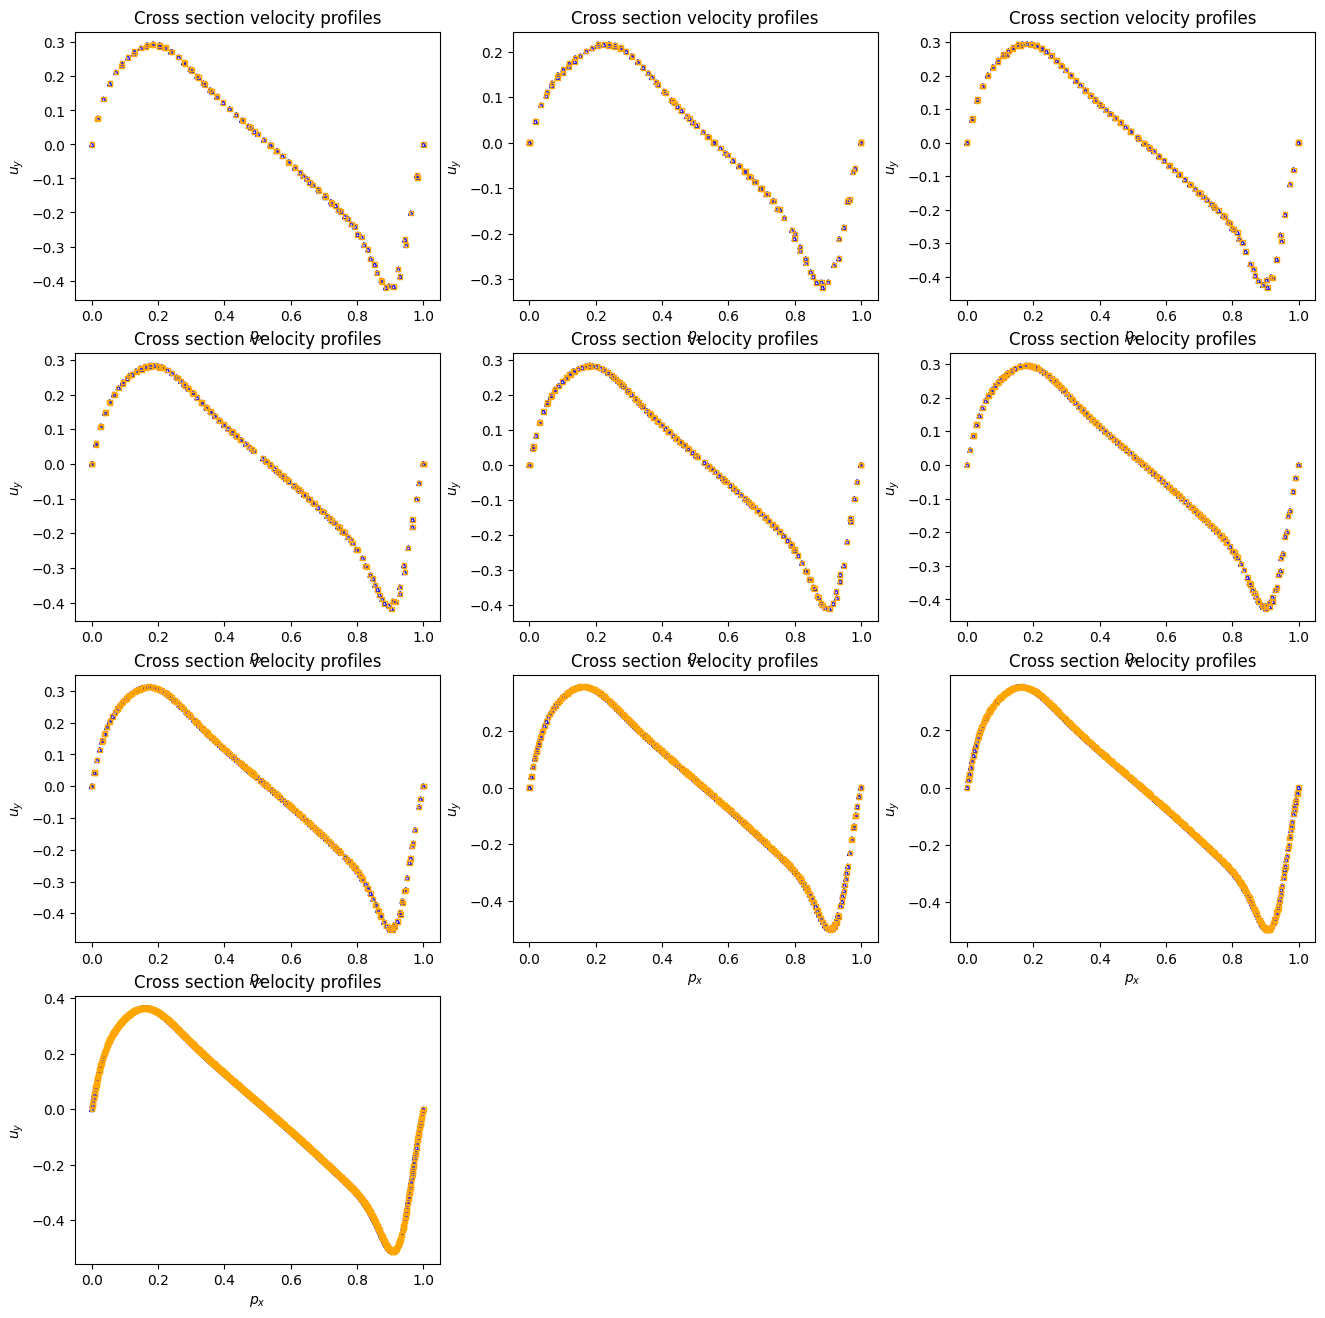

In [ ]:
# fig, axs = plt.subplots(len(hs_acm), figsize=(8,64))
# fig, axs = plt.subplots(4, 3, figsize=(16,16))
fig, ax = plt.subplots()
markers = ['^', 's']
colors = ['blue', 'orange']
# colors = ['red', 'blue', 'green', 'purple', 'orange']
# markers = ['s', '^', '+', 'D']
# for i, h in enumerate(hs_acm):
h = hs_acm[-3]
for j, (name, program) in enumerate(programs_acm.items()):
    result_file = Path('..') / get_output_path(program, h)
    with h5py.File(result_file) as f:
        u = np.array(f['velocity'], dtype=np.float64)
        pos = np.array(f['domain/pos'], dtype=np.float64)
        midplane_velocity_profile(ax, pos, u, h, markers[j], colors[j])
# [fig.delaxes(ax) for ax in axs.flatten() if not ax.has_data()]